In [ ]:
# Ridge Regulariation CV Using Small Theta and Large Theta Regime Assumption.
# The external code for this Ridge Regularisation is same as that for Elastic Net CV, just the type regularisation block is changed.

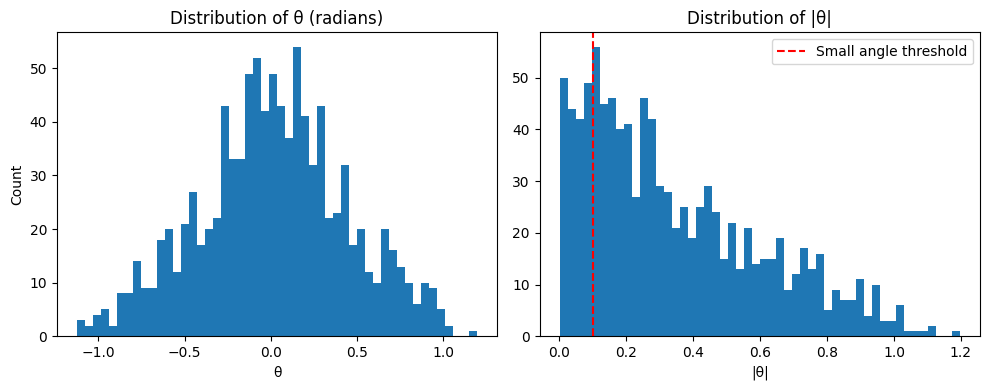

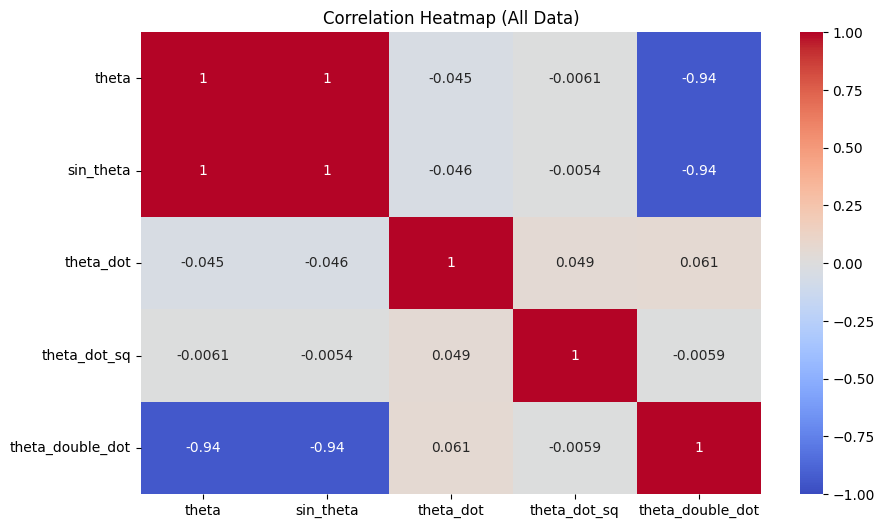

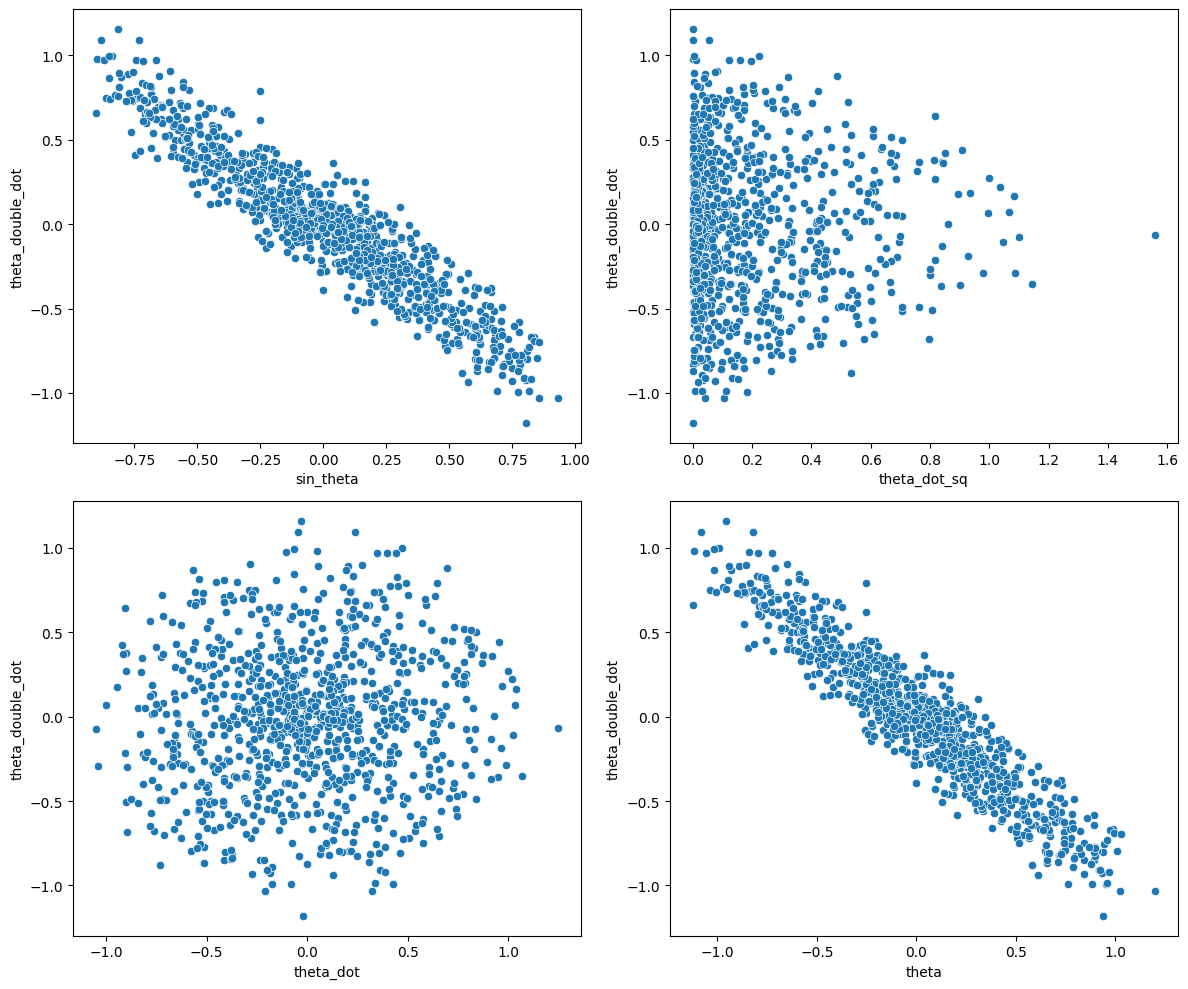


=== Regime Statistics ===
regime
large    806
small    194
Name: count, dtype: int64

Small-angle proportion: 19.4%


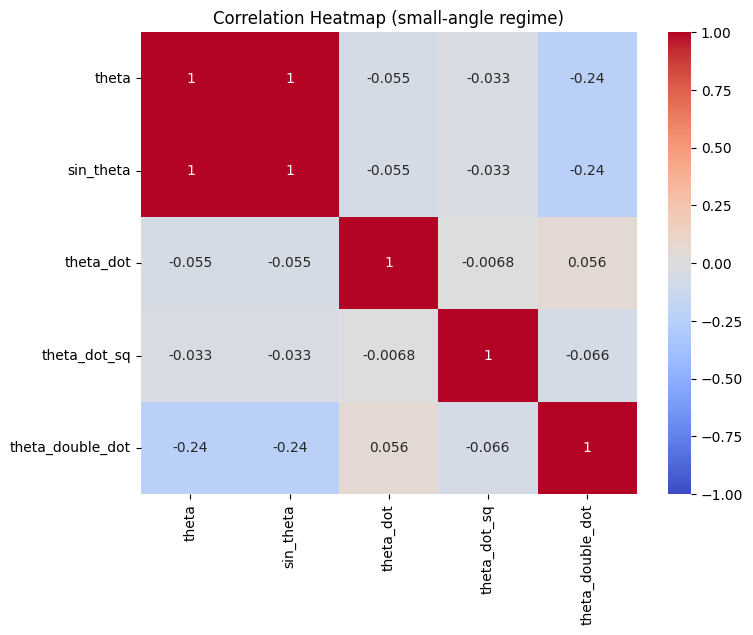

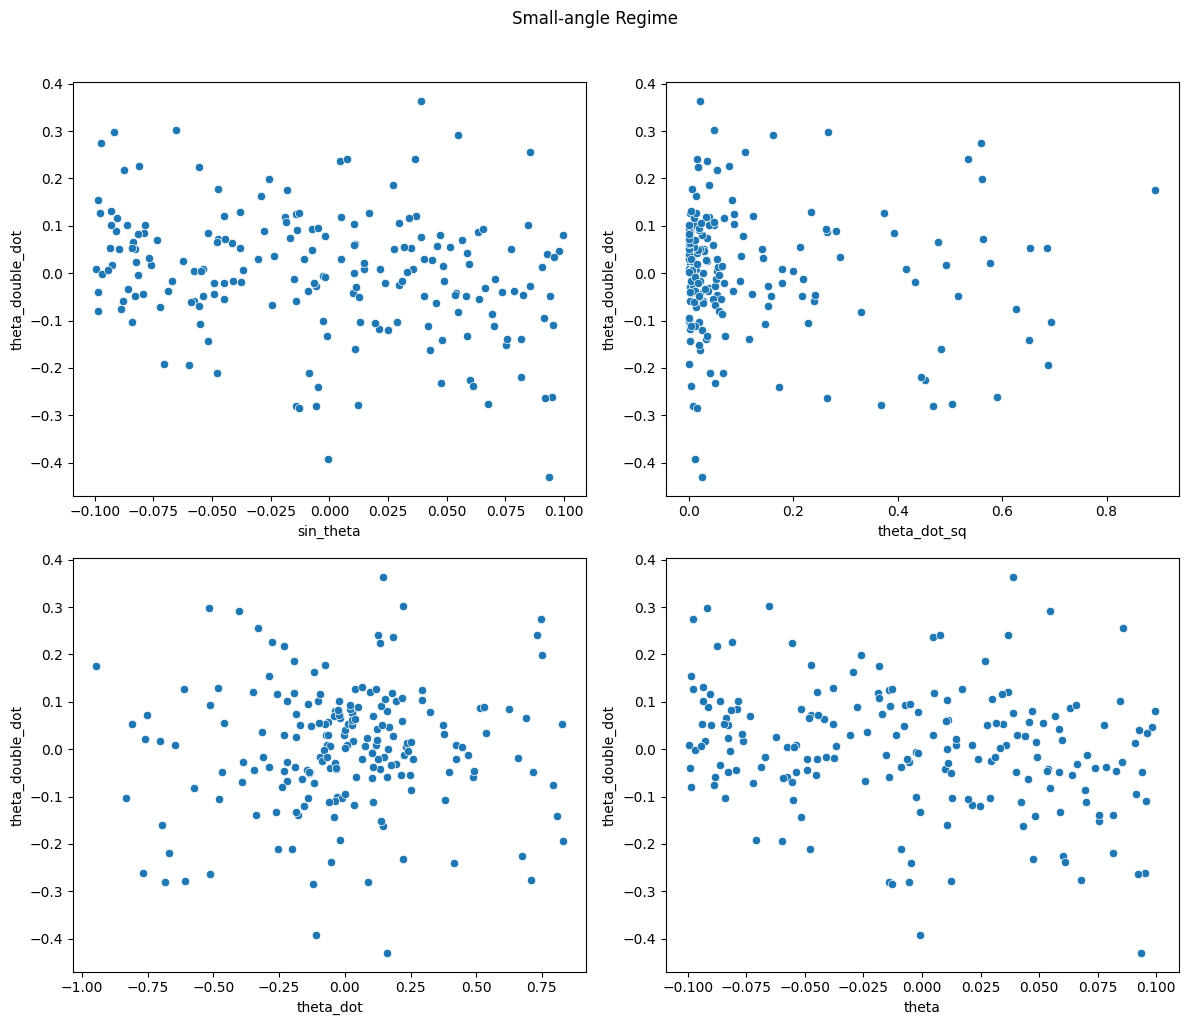

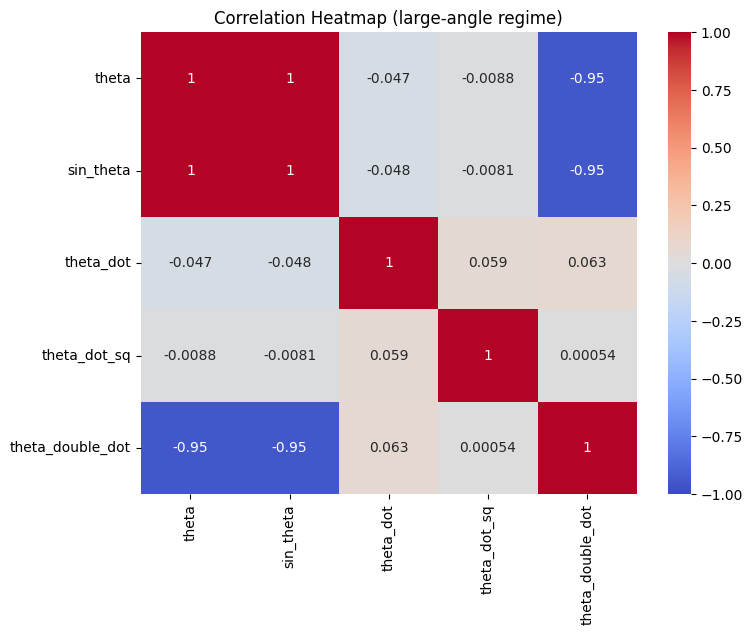

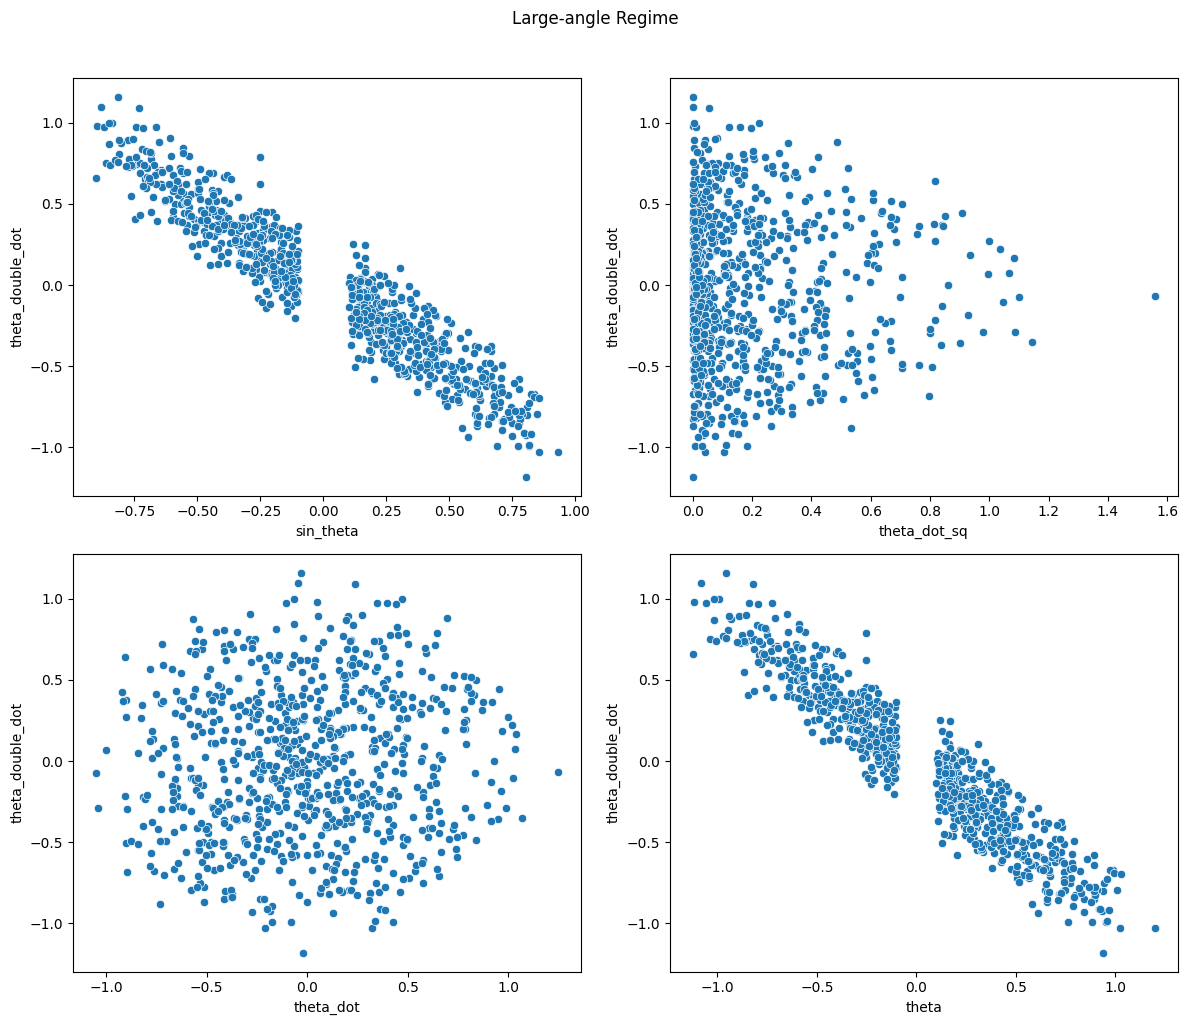


=== Model Results ===
  regime  n_samples       mse  optimal_alpha
0  small        194  0.016163      79.248290
1  large        806  0.020696       3.351603

=== Detailed Coefficients ===

small-angle model:
       theta: -0.0127
   sin_theta: -0.0127
   theta_dot: 0.0041
theta_dot_sq: -0.0066
   intercept: 0.0009
         MSE: 0.0162
       alpha: 79.2483

large-angle model:
       theta: -0.2310
   sin_theta: -0.2041
   theta_dot: 0.0085
theta_dot_sq: -0.0039
   intercept: -0.0260
         MSE: 0.0207
       alpha: 3.3516

=== Test Predictions ===
θ=0.05, θ̇=0.10 → predicted θ̈=-0.0176 (regime: small)
θ=0.50, θ̇=0.20 → predicted θ̈=-0.4655 (regime: large)
θ=1.00, θ̇=-0.30 → predicted θ̈=-0.8865 (regime: large)


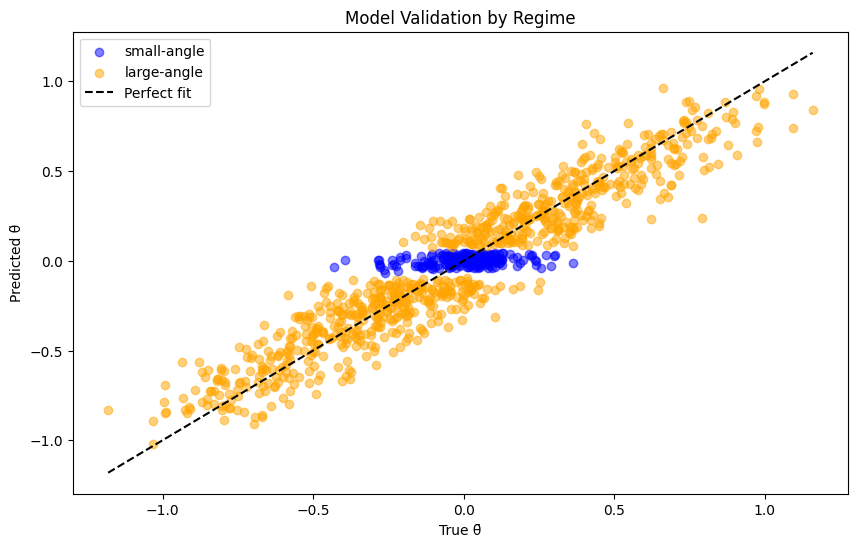

In [1]:
# ======================
# 1. Import Libraries
# ======================
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For plotting and visualization
import seaborn as sns  # For enhanced visualizations
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.linear_model import RidgeCV  # Ridge regression with built-in cross-validation
from sklearn.model_selection import cross_val_score  # For cross-validation evaluation
import os  # For directory creation

# Create directory to store Ridge-related plots
os.makedirs('ridge_regularisation', exist_ok=True)

# ======================
# 2. Load and Prepare Data
# ======================
# Load pendulum dynamics data from CSV file
data = pd.read_csv('pendulum_data.csv')

# Create derived features that are physically meaningful for pendulum dynamics:
# - sin(theta) because pendulum motion depends on sine of the angle
# - theta_dot squared because energy terms often involve squared velocities
data['sin_theta'] = np.sin(data['theta'])
data['theta_dot_sq'] = data['theta_dot']**2

# ======================
# 3. Exploratory Data Analysis
# ======================
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(data['theta'], bins=50)
plt.title('Distribution of θ (radians)')
plt.xlabel('θ')
plt.ylabel('Count')

plt.subplot(122)
plt.hist(np.abs(data['theta']), bins=50)
plt.title('Distribution of |θ|')
plt.axvline(0.1, color='r', linestyle='--', label='Small angle threshold')
plt.xlabel('|θ|')
plt.legend()
plt.tight_layout()
plt.savefig('ridge_regularisation/theta_distribution_ridge.png')
plt.show()

# ======================
# 4. Correlation Analysis (All Data)
# ======================
corr_matrix = data[['theta', 'sin_theta', 'theta_dot', 'theta_dot_sq', 'theta_double_dot']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap (All Data)")
plt.savefig('ridge_regularisation/correlation_heatmap_all_ridge.png')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.scatterplot(x='sin_theta', y='theta_double_dot', data=data, ax=axes[0, 0])
sns.scatterplot(x='theta_dot_sq', y='theta_double_dot', data=data, ax=axes[0, 1])
sns.scatterplot(x='theta_dot', y='theta_double_dot', data=data, ax=axes[1, 0])
sns.scatterplot(x='theta', y='theta_double_dot', data=data, ax=axes[1, 1])
plt.tight_layout()
plt.savefig('ridge_regularisation/scatter_plots_all_ridge.png')
plt.show()

# ======================
# 5. Regime Classification
# ======================
def classify_regime(theta, threshold=0.1):
    return 'small' if np.abs(theta) < threshold else 'large'

data['regime'] = data['theta'].apply(classify_regime)

print("\n=== Regime Statistics ===")
print(data['regime'].value_counts())
print(f"\nSmall-angle proportion: {len(data[data['regime'] == 'small'])/len(data):.1%}")

# ======================
# 6. Regime-Specific Analysis
# ======================
for regime in ['small', 'large']:
    regime_data = data[data['regime'] == regime]
    
    corr_matrix = regime_data[['theta', 'sin_theta', 'theta_dot', 'theta_dot_sq', 'theta_double_dot']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap ({regime}-angle regime)")
    plt.savefig(f'ridge_regularisation/correlation_heatmap_{regime}_ridge.png')
    plt.show()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    sns.scatterplot(x='sin_theta', y='theta_double_dot', data=regime_data, ax=axes[0, 0])
    sns.scatterplot(x='theta_dot_sq', y='theta_double_dot', data=regime_data, ax=axes[0, 1])
    sns.scatterplot(x='theta_dot', y='theta_double_dot', data=regime_data, ax=axes[1, 0])
    sns.scatterplot(x='theta', y='theta_double_dot', data=regime_data, ax=axes[1, 1])
    plt.suptitle(f'{regime.capitalize()}-angle Regime', y=1.02)
    plt.tight_layout()
    plt.savefig(f'ridge_regularisation/scatter_plots_{regime}_ridge.png')
    plt.show()

# ======================
# 7. Model Training with Ridge Regression
# ======================
models = {}
scalers = {}
results = []

for regime in ['small', 'large']:
    mask = data['regime'] == regime
    features = ['theta', 'sin_theta', 'theta_dot', 'theta_dot_sq']
    
    X = data.loc[mask, features]
    y = data.loc[mask, 'theta_double_dot']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=features)
    
    model = RidgeCV(alphas=np.logspace(-4, 4, 100),
                    cv=5,
                    scoring='neg_mean_squared_error')
    model.fit(X_scaled, y)
    
    models[regime] = model
    scalers[regime] = scaler
    
    mse = -cross_val_score(model, X_scaled, y, cv=5, scoring='neg_mean_squared_error').mean()
    results.append({
        'regime': regime,
        'n_samples': sum(mask),
        'features': features,
        'coefficients': model.coef_,
        'intercept': model.intercept_,
        'mse': mse,
        'optimal_alpha': model.alpha_
    })

# ======================
# 8. Model Results
# ======================
results_df = pd.DataFrame(results)
print("\n=== Model Results ===")
print(results_df[['regime', 'n_samples', 'mse', 'optimal_alpha']])

print("\n=== Detailed Coefficients ===")
for regime in ['small', 'large']:
    print(f"\n{regime}-angle model:")
    model = models[regime]
    features = results_df[results_df['regime'] == regime]['features'].iloc[0]
    for feat, coef in zip(features, model.coef_):
        print(f"{feat:>12}: {coef:.4f}")
    print(f"{'intercept':>12}: {model.intercept_:.4f}")
    print(f"{'MSE':>12}: {results_df[results_df['regime'] == regime]['mse'].iloc[0]:.4f}")
    print(f"{'alpha':>12}: {model.alpha_:.4f}")

# ======================
# 9. Prediction System
# ======================
def predict_acceleration(theta, theta_dot):
    regime = classify_regime(theta)
    input_data = pd.DataFrame([[theta, np.sin(theta), theta_dot, theta_dot**2]],
                              columns=['theta', 'sin_theta', 'theta_dot', 'theta_dot_sq'])
    x_scaled = scalers[regime].transform(input_data)
    x_scaled_df = pd.DataFrame(x_scaled, columns=scalers[regime].feature_names_in_)
    return models[regime].predict(x_scaled_df)[0]

test_cases = [
    (0.05, 0.1),
    (0.5, 0.2),
    (1.0, -0.3)
]

print("\n=== Test Predictions ===")
for theta, theta_dot in test_cases:
    pred = predict_acceleration(theta, theta_dot)
    print(f"θ={theta:.2f}, θ̇={theta_dot:.2f} → predicted θ̈={pred:.4f} (regime: {classify_regime(theta)})")

# ======================
# 10. Model Validation
# ======================
data['predicted'] = [predict_acceleration(t, td) for t, td in zip(data['theta'], data['theta_dot'])]

plt.figure(figsize=(10, 6))
for regime, color in zip(['small', 'large'], ['blue', 'orange']):
    mask = data['regime'] == regime
    plt.scatter(data.loc[mask, 'theta_double_dot'], data.loc[mask, 'predicted'],
                alpha=0.5, label=f'{regime}-angle', color=color)
    
plt.plot([data['theta_double_dot'].min(), data['theta_double_dot'].max()],
         [data['theta_double_dot'].min(), data['theta_double_dot'].max()],
         'k--', label='Perfect fit')
plt.xlabel('True θ̈')
plt.ylabel('Predicted θ̈')
plt.title('Model Validation by Regime')
plt.legend()
plt.savefig('ridge_regularisation/model_validation_ridge.png')
plt.show()
